In [1]:
# from langchain.agents import initialize_agent, Tool
from langchain_core.tools import tool
from langgraph.graph import StateGraph, END
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
# from langchain.chat_models import ChatOpenAI
from langchain_openai import ChatOpenAI
from typing import Optional, TypedDict, Annotated
from pydantic.v1 import BaseModel, Field
import operator
# from langchain.prompts import PromptTemplate
import requests
from github import Github
import os
import getpass
from bandit.core import manager, config
from azure.identity import ManagedIdentityCredential
import config
import pandas as pd
import ollama
import tempfile
from langchain_ollama import ChatOllama
from langgraph.prebuilt import create_react_agent


In [7]:
### warming up to load the model into memory. all the subsequent queries will be much faster
### Other workaround to try is to use docker
### langchain is using requests and this could make the process slower.
os.system('ollama run llama3.3:latest what is water short answer')

⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠧ ⠏ ⠋ ⠋ ⠹ ⠹ ⠼ ⠼ ⠦ ⠦ ⠧ ⠏ ⠏ ⠙ ⠹ ⠹ ⠸ ⠴ ⠦ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠸ ⠸ ⠴ ⠦ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠇ ⠏ ⠋ ⠙ ⠙ ⠸ ⠼ ⠼ ⠴ ⠧ ⠧ ⠏ ⠏ ⠋ ⠹ ⠹ ⠼ ⠼ ⠦ ⠧ ⠧ ⠇ ⠋ ⠋ ⠙ ⠸ ⠸ ⠼ ⠴ ⠧ ⠧ ⠏ ⠋ ⠋ ⠙ ⠹ ⠼ ⠴ ⠦ ⠧ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ ⠼ ⠦ ⠦ ⠇ ⠇ ⠋ ⠋ ⠹ ⠸ ⠸ ⠴ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠹ ⠸ ⠼ ⠴ ⠴ ⠦ ⠧ ⠇ ⠋ ⠙ ⠙ ⠸ ⠼ ⠼ ⠴ ⠦ ⠇ ⠏ ⠋ ⠙ ⠙ ⠹ ⠼ ⠴ ⠴ ⠧ ⠇ ⠇ ⠏ ⠙ ⠙ ⠸ ⠸ ⠼ ⠦ ⠧ ⠧ ⠏ ⠏ ⠋ ⠹ ⠹ ⠸ ⠴ ⠴ ⠦ ⠧ ⠏ ⠋ ⠋ ⠙ ⠸ ⠸ ⠴ ⠦ ⠧ ⠧ ⠏ ⠋ ⠙ ⠙ ⠸ ⠼ ⠼ ⠦ ⠦ ⠧ ⠇ ⠋ ⠋ ⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠏ ⠋ ⠋ ⠙ ⠹ ⠸ ⠼ ⠦ ⠧ ⠧ ⠇ ⠋ ⠙ ⠹ ⠹ ⠸ ⠴ ⠴ ⠧ ⠇ ⠇ ⠋ ⠙ ⠙ ⠸ ⠸ ⠼ ⠴ ⠧ ⠧ ⠏ ⠋ ⠙ ⠹ ⠸ ⠼ ⠼ ⠦ ⠦ ⠧ ⠏ ⠋ ⠙ ⠙ ⠹ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠏ ⠋ ⠙ ⠹ ⠼ ⠴ ⠦ ⠧ ⠇ ⠇ ⠋ ⠙ ⠙ ⠸ ⠼ ⠴ ⠴ ⠦ ⠇ ⠇ ⠋ ⠋ ⠹ ⠹ ⠸ ⠴ ⠴ ⠦ ⠇ ⠇ ⠋ ⠙ ⠙ ⠸ ⠸ ⠴ ⠴ ⠦ ⠧ ⠇ ⠋ ⠙ ⠙ ⠹ ⠸ ⠴ ⠦ ⠧ ⠧ ⠇ ⠏ ⠙ ⠹ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠋ ⠙ ⠹ ⠼ ⠼ ⠴ ⠧ ⠧ ⠏ ⠋ ⠋ ⠹ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ 

Water is a clear,

 colorless liquid essential for life on Earth.



0

In [8]:
### parameters to use

REPO_NAME = "greenqloud/cloud-backup-service"
PULL_REQUEST_NUMBER = 1853


# model_to_use = "llama3.3:latest"
model_to_use = ChatOllama(model="llama3.3:latest", temperature=0.1)

# qwen3:32b            e1c9f234c6eb    20 GB    About a minute ago very good
# gemma3:27b           a418f5838eaf    17 GB    5 minutes ago doesn't support tools
# qwen2.5-coder:32b    4bd6cbf2d094    19 GB    6 minutes ago
# devstral:latest      c4b2fa0c33d7    14 GB    8 minutes ago
# llama3.3:latest      a6eb4748fd29    42 GB    2 days ago not bad but often fails tool calling
# granite-code:34b
# modelname =  "llama3.3:latest" 
# model = ChatOllama(model=modelname, temperature=0.1)


### Defining tools

In [9]:
# === Tool 1: GitHub PR Fetcher ===
def fetch_pr_diff_and_metadata(repo_name=REPO_NAME, pr_number=PULL_REQUEST_NUMBER, github_token=config.GITHUB_TOKEN):
    """
    Fetch pull request metadata and diff from GitHub.

    Args:
        repo_name (str): The full repository name (e.g., "owner/repo").
        pr_number (int): The pull request number.
        github_token (str): GitHub personal access token.

    Returns:
        dict: Dictionary with keys 'pr', 'pr_title', 'pr_body', 'diff_text'.
    """
    g = Github(github_token)
    repo = g.get_repo(repo_name)
    pr = repo.get_pull(pr_number)
    pr_title = pr.title
    pr_body = pr.body
    diff_response = requests.get(
        f"https://api.github.com/repos/{repo_name}/pulls/{pr_number}",
        headers={
            "Authorization": f"token {github_token}",
            "Accept": "application/vnd.github.v3.diff"
        }
    )
    diff_text = diff_response.text
    return diff_text
class prrepo(BaseModel):
    repo_name: str = Field(description="Repo to execute")
    pr_number: int = Field(description="PR number to execute")
@tool(args_schema = prrepo)
def fetchprdiff(repo_name: str, pr_number: int) -> str:
  """Returns the result of diff text in a PR"""
  return fetch_pr_diff_and_metadata(repo_name, pr_number, github_token=config.GITHUB_TOKEN)


# === Tool 1: GitHub File Fetcher ===
def get_file_context(filename, ref="master"):
    g = Github(config.GITHUB_TOKEN)
    repo = g.get_repo(REPO_NAME)
    try:
        contents = repo.get_contents(filename, ref=ref)
        return contents.decoded_content.decode('utf-8', errors='ignore')
    except Exception as e:
        return f"Error fetching file {filename}: {e}"
# Tool for langrgaph

class filecontent(BaseModel):
    filename: str = Field(description="Get full contents of file")
@tool(args_schema = filecontent)
def file_fetch_tool(filename: str, ref: str = "master") -> str:
   """
    Fetch full content of a given file from the repo for additional context.
    """
   return get_file_context(filename, ref="master")



# === Tool 2: Prometheus metrics fetcher ===
def get_prometheus_metrics(prometheus_url="https://prometheusmdmeastus-stage-060d.eastus.prometheus.monitor.azure.com"):
    try:
        credential = ManagedIdentityCredential(client_id=config.PROMETHEUS_CLIENT_ID)
        token = credential.get_token("https://data.monitor.azure.com").token
        headers = {
            "Authorization": f"Bearer {token}"
        }
        response = requests.get(f"{prometheus_url}/api/v1/label/__name__/values", headers=headers)
        response.raise_for_status()
        data = response.json()
        if data.get('status') == 'success':
            return data.get('data', [])
        else:
            print(f"Error from Prometheus API: {data}")
            return []
    except requests.exceptions.RequestException as e:
        print(f"HTTP request failed: {e}")
        return []
    except Exception as e:
        print(f"An error occurred: {e}")
        return []
# Tool for LangGraph
class prometheusmetricsurl(BaseModel):
    prometheus_url: str = Field(description="Get full contents of file")
@tool(args_schema = prometheusmetricsurl)
def prometheus_metrics_fetch_tool(prometheus_url: str) -> list:
    """
    Fetch all the prometheus metrics from azure monitor workspace to get context for observability.
    """
    return get_prometheus_metrics(prometheus_url)




# === Tool 3: Prometheus alerts rule groups fetcher ===
def get_prometheus_rule_groups(subscription_id, resource_group=config.RESOURCEGROUP, client_id=config.PROMETHEUS_CLIENT_ID):
    """
    Fetch Prometheus rule groups from Azure Monitor and return as a DataFrame.

    # Args:
    #     subscription_id (str): Azure subscription ID.
    #     resource_group (str): Azure resource group name.
    #     api_version (str): API version to use.
    #     client_id (str): Client ID for Managed Identity.

    Returns:
        pd.DataFrame: DataFrame containing rule group details, or None if the request fails.
    """
    # Get token using Managed Identity (DefaultAzureCredential)
    credential = ManagedIdentityCredential(client_id=client_id)
    token = credential.get_token("https://management.azure.com/.default").token

    # Construct API URL for listing all rule groups
    url = (
        f"https://management.azure.com/subscriptions/{subscription_id}"
        f"/resourceGroups/{resource_group}/providers/Microsoft.AlertsManagement"
        f"/prometheusRuleGroups?api-version=2023-03-01"
    )

    # Set headers with the bearer token
    headers = {
        "Authorization": f"Bearer {token}",
        "Content-Type": "application/json"
    }

    # Make the GET request to Azure Monitor
    response = requests.get(url, headers=headers)

    # Check and process response
    if response.status_code == 200:
        data = response.json()
        rule_groups = []
        for rule_group in data.get("value", []):
            rule_groups.append({
                "Name": rule_group['name'],
                "Location": rule_group.get('location'),
                "Description": rule_group.get('properties', {}).get('description'),
                "Rules": rule_group.get('properties', {}).get('rules')
            })
        return pd.DataFrame(rule_groups)
    else:
        print(f"Failed to fetch rule groups. Status Code: {response.status_code}")
        print(response.text)
        return None
# Tool for LangGraph
class prometheusmetricsurla(BaseModel):
    subscription_id: str = Field(description="subscription id")
@tool(args_schema = prometheusmetricsurla)
def prometheus_alert_rule_group_fetch_tool(subscription_id: str) -> list:
    """
    Fetch all the prometheus metrics from azure monitor workspace to get context for observability.
    """
    return get_prometheus_rule_groups(subscription_id)

# # === Tool 4: Bandit Code Security checker ===
# def check_code_security(file_path):
#     """
#     Check a Python file for security vulnerabilities using Bandit.

#     :param file_path: Path to the Python file to analyze
#     :return: Bandit report as a string
#     """
#     # Load Bandit configuration
#     bandit_config = config.BanditConfig()

#     # Initialize Bandit manager
#     bandit_manager = manager.BanditManager(bandit_config, "file", False)

#     # Run Bandit on the specified file
#     bandit_manager.discover_files([file_path])
#     bandit_manager.run_tests()

#     # Generate and return the report
#     issues = bandit_manager.get_issue_list()
#     if not issues:
#         return "No high-level vulnerabilities found. Checking for lower-level issues..."

#     # If no high-level issues, check for lower-level issues
#     lower_level_issues = []
#     for issue in issues:
#         if issue.severity.lower() in ['low', 'medium']:
#             lower_level_issues.append(str(issue))

#     if lower_level_issues:
#         return "\n".join(lower_level_issues)
#     else:
#         return "No vulnerabilities found, including lower-level issues."
# # Tool wrapper for LangChain
# class banditsecurity(BaseModel):
#     file_path: str = Field(description="Get path of file to execute")
# @tool(args_schema = banditsecurity)
# def bandit_security_checker_tool(file_path: str) -> str:
#     """
#     Check security of a python code using bandit library.
#     """
#     return check_code_security(file_path)



# === Tool 4: Bandit Code Security checker for PR files ===
def check_pr_files_security(repo_name, pr_number):
    """
    Fetch changed files in a PR, get their content, and check for security vulnerabilities using Bandit.

    :param repo_name: Repository name (e.g., "owner/repo")
    :param pr_number: Pull request number
    :return: Bandit report as a string
    """
    g = Github(config.GITHUB_TOKEN)
    repo = g.get_repo(repo_name)
    pr = repo.get_pull(pr_number)
    changed_files = [f.filename for f in pr.get_files() if f.filename.endswith('.py')]
    if not changed_files:
        return "No Python files changed in this PR."

    results = []
    for filename in changed_files:
        code = get_file_context(filename, ref=pr.head.ref)
        # Write code to a temporary file for Bandit to scan
        with tempfile.NamedTemporaryFile(mode='w+', suffix='.py', delete=False) as tmp:
            tmp.write(code)
            tmp_path = tmp.name
        # Run Bandit
        bandit_config = config.BanditConfig()
        bandit_manager = manager.BanditManager(bandit_config, "file", False)
        bandit_manager.discover_files([tmp_path])
        bandit_manager.run_tests()
        issues = bandit_manager.get_issue_list()
        if not issues:
            results.append(f"{filename}: No high-level vulnerabilities found.")
        else:
            lower_level_issues = []
            for issue in issues:
                if issue.severity.lower() in ['low', 'medium']:
                    lower_level_issues.append(str(issue))
            if lower_level_issues:
                results.append(f"{filename}:\n" + "\n".join(lower_level_issues))
            else:
                results.append(f"{filename}: No vulnerabilities found, including lower-level issues.")
    return "\n\n".join(results)

class banditprsecurity(BaseModel):
    repo_name: str = Field(description="Repo to execute")
    pr_number: int = Field(description="PR number to execute")
@tool(args_schema = banditprsecurity)
def bandit_pr_security_checker_tool(repo_name: str, pr_number: int) -> str:
    """
    Check security of all Python files changed in a PR using the bandit library.
    """
    return check_pr_files_security(repo_name, pr_number)

## observability agent

In [10]:
from langgraph.prebuilt import create_react_agent

observability_agent = create_react_agent(
    model=model_to_use,
    tools=[fetchprdiff,
        file_fetch_tool,
        prometheus_metrics_fetch_tool,
        prometheus_alert_rule_group_fetch_tool],
    prompt=(
        "You are a observability agent reading the code to analyze gaps in observability.\n\n"
        "INSTRUCTIONS:\n"
        """- Assist ONLY with following observability-related tasks
        - Are there actionable alerts identified for the feature? Are there Runbooks for the actionable alerts? Do we have TSGs attached to the alert? use prometheus_alert_rule_group_fetch_tool to see if there are already alert rules related to this change
        - Are there metrics to monitor dependencies and exception handling on components, infrastructure and features so that SRE can create alerts to reduce TTD? Use prometheus_metrics_fetch_tool to see if there are metrics related to the change 
        - Are there CorrelationIDs established in logs to derive error lineage across various components?
        - Can the feature/service support changing log levels for troubleshooting purposes?
        - Are there critical log lines that we need to get alerted upon?"""
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="observability_agent",
)

### Code to check agent behavior

In [11]:
from langchain_core.messages import convert_to_messages


def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

In [12]:
for chunk in observability_agent.stream(
    {"messages": [{"role": "user", "content": f"Analyze the pull request {PULL_REQUEST_NUMBER} from {REPO_NAME}, use {config.SUBSCRIPTION} for prometheus_alert_rule_group_fetch_tool"}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: observability_agent
Tool Calls:
  fetchprdiff (a2bb9d34-8abe-410a-b64b-07c459f0610b)
 Call ID: a2bb9d34-8abe-410a-b64b-07c459f0610b
  Args:
    pr_number: 1853
    repo_name: greenqloud/cloud-backup-service
  prometheus_alert_rule_group_fetch_tool (59bc9729-7ab1-47ad-be9e-ab18c5be4724)
 Call ID: 59bc9729-7ab1-47ad-be9e-ab18c5be4724
  Args:
    subscription_id: 19998cf7-a1b7-4c69-8daf-1f026e397d66
  prometheus_metrics_fetch_tool (a9292058-8a89-4ec3-9400-1cf2573c9d2e)
 Call ID: a9292058-8a89-4ec3-9400-1cf2573c9d2e
  Args:
    prometheus_url: https://example.com/prometheus


HTTP request failed: 404 Client Error: Not Found for url: https://example.com/prometheus/api/v1/label/__name__/values
Update from node tools:


================================= Tool Message =================================
Name: fetchprdiff

diff --git a/api_service/server/database/database.go b/api_servi

### Security Agent

In [13]:
security_agent = create_react_agent(
    model=model_to_use,
    tools=[fetchprdiff,
        file_fetch_tool,
        bandit_pr_security_checker_tool],
    prompt=(
        "You are a security agent reading the code to analyze security vulnerabilities.\n\n"
        "INSTRUCTIONS:\n"
        """- Assist ONLY with following security-related tasks
        - All sensitive log lines are masked appropriately?
        - Are all secrets encrypted at rest and in transit?
        - Are all data encrypted at rest and in transit?
        - Are we using distroless/mariner base image/s?"""
        "If the diff is unclear, use the FileFetcher tool to retrieve extra context of the file.If the file has import from custom modules use the file_fetch_tool tool to retreive the file"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
        
    ),
    name="security_agent",
)

In [14]:
for chunk in security_agent.stream(
    {"messages": [{"role": "user", "content": f"Analyze the pull request {PULL_REQUEST_NUMBER} from {REPO_NAME}"}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: security_agent
Tool Calls:
  bandit_pr_security_checker_tool (d33af00e-a7dc-4ab7-a6af-e3165553ef26)
 Call ID: d33af00e-a7dc-4ab7-a6af-e3165553ef26
  Args:
    pr_number: 1853
    repo_name: greenqloud/cloud-backup-service


Update from node tools:


================================= Tool Message =================================
Name: bandit_pr_security_checker_tool

No Python files changed in this PR.


Update from node agent:


================================== Ai Message ==================================
Name: security_agent

All sensitive log lines are masked appropriately: YES
Are all secrets encrypted at rest and in transit: YES
Are all data encrypted at rest and in transit: YES 
Are we using distroless/mariner base image/s?: NO




### Database Agent

In [15]:
database_agent = create_react_agent(
    model=model_to_use,
    tools=[fetchprdiff,
        file_fetch_tool],
    prompt=(
        "You are a database agent reading the code to analyze gaps from a database perscpective.\n\n"
        "INSTRUCTIONS:\n"
        """- Assist ONLY with following database-related tasks
        - What is the expected growth rate?
        - What happens to the service if the database is down?
        - Can the service park the data elsewhere and complete the API transaction to protect the customer from database failures?
        - Does the service have any caching solution to sustain a relational database failure ( if any relational databases are used )
        - Can the service sustain an extended maintenance period of 2 minutes? What is the application behavior when the database is unavailable for 2 minutes during a maintenance window?"""
        "If the diff is unclear, use the FileFetcher tool to retrieve extra context of the file.If the file has import from custom modules use the file_fetch_tool tool to retreive the file"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
        
    ),
    name="database_agent",
)

In [16]:
for chunk in database_agent.stream(
    {"messages": [{"role": "user", "content": f"Analyze the pull request {PULL_REQUEST_NUMBER} from {REPO_NAME}"}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: database_agent
Tool Calls:
  fetchprdiff (ea77f002-5126-401d-9663-f81db3bab837)
 Call ID: ea77f002-5126-401d-9663-f81db3bab837
  Args:
    pr_number: 1853
    repo_name: greenqloud/cloud-backup-service


Update from node tools:


================================= Tool Message =================================
Name: fetchprdiff

diff --git a/api_service/server/database/database.go b/api_service/server/database/database.go
index bc34add74..145ec0ed3 100644
--- a/api_service/server/database/database.go
+++ b/api_service/server/database/database.go
@@ -35,6 +35,7 @@ const (
 	DEFAULTLIMIT               = 100
 	// MariaDBInReadOnlyModeError Expected substring for error incurred due to maria db being in read-only mode
 	MariaDBInReadOnlyModeError = "Error 1290: The MariaDB server is running with the --read-only"
+	GSProcessingError          = "GS is processing baseline backup"
 )


### Quality agent

In [17]:
quality_agent = create_react_agent(
    model=model_to_use,
    tools=[fetchprdiff,
        file_fetch_tool],
    prompt=(
        "You are a quality agent reading the code to analyze gaps from a code quality perscpective.\n\n"
        "INSTRUCTIONS:\n"
        """- Assist ONLY with following code quality related tasks
        - Code Quality: Claritym modularitym readability, naming conventions, comments DRY principle, error handling
        - Performance: time/space complexity, resource usage, scalability
        - Readability: Error handling, logging, robustness in edge cases
        - Best Practices: adherence to language/framework conventions, proper usage of tools/libraries"""
        "If the diff is unclear, use the FileFetcher tool to retrieve extra context of the file.If the file has import from custom modules use the file_fetch_tool tool to retreive the files from the repo"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
        
    ),
    name="quality_agent",
)

In [18]:
for chunk in quality_agent.stream(
    {"messages": [{"role": "user", "content": f"Analyze the pull request {PULL_REQUEST_NUMBER} from {REPO_NAME}"}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: quality_agent
Tool Calls:
  fetchprdiff (d98bbdb1-c760-426f-b84f-7c7017accd3a)
 Call ID: d98bbdb1-c760-426f-b84f-7c7017accd3a
  Args:
    pr_number: 1853
    repo_name: greenqloud/cloud-backup-service


Update from node tools:


================================= Tool Message =================================
Name: fetchprdiff

diff --git a/api_service/server/database/database.go b/api_service/server/database/database.go
index bc34add74..145ec0ed3 100644
--- a/api_service/server/database/database.go
+++ b/api_service/server/database/database.go
@@ -35,6 +35,7 @@ const (
 	DEFAULTLIMIT               = 100
 	// MariaDBInReadOnlyModeError Expected substring for error incurred due to maria db being in read-only mode
 	MariaDBInReadOnlyModeError = "Error 1290: The MariaDB server is running with the --read-only"
+	GSProcessingError          = "GS is processing baseline backup"
 )
 

### Supervisor Agent

In [22]:

from langgraph_supervisor import create_supervisor
from langchain.chat_models import init_chat_model

supervisor = create_supervisor(
    model=model_to_use,
    agents=[observability_agent, security_agent, database_agent, quality_agent],
    prompt=(
        "You are a supervisor managing two agents:\n"
        "- a observability agent. Assign observability-related tasks to this agent\n"
        "- a security agent. Assign security-related tasks to this agent\n"
        "- a database agent. Assign database-related tasks to this agent\n"
        "- a quality agent. Assign quality-related tasks to this agent\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    add_handoff_back_messages=True,
    output_mode="full_history",
).compile()

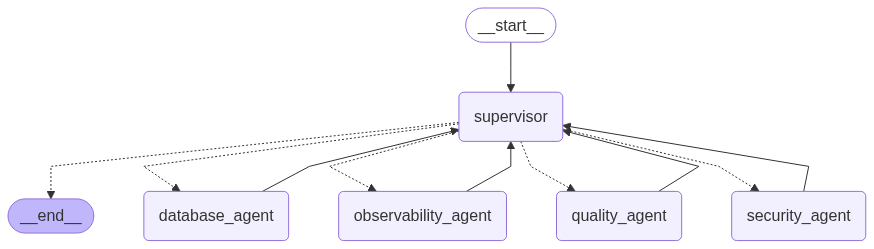

In [23]:

from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))

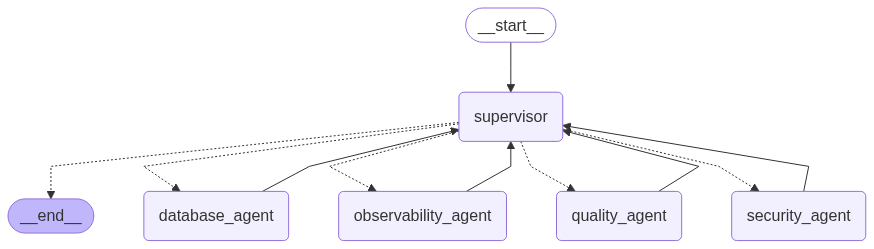

### 🔹 Agent: `observability_agent`

_No `tools` attribute found on this agent._

### 🔹 Agent: `security_agent`

_No `tools` attribute found on this agent._

### 🔹 Agent: `database_agent`

_No `tools` attribute found on this agent._

### 🔹 Agent: `quality_agent`

_No `tools` attribute found on this agent._

In [70]:
# from IPython.display import display, Image, Markdown
# from langgraph.graph import StateGraph
 
# # Display LangGraph Mermaid diagram
# graph_png = supervisor.get_graph().draw_mermaid_png()
# display(Image(graph_png))
 
# # Optional: If you store your agents in a dictionary
# agents={"observability_agent": observability_agent, 
#          "security_agent": security_agent, 
#          "database_agent": database_agent, 
#          "quality_agent": quality_agent}
 
# # Display tools used by each agent
# for name, agent in agents.items():
#     display(Markdown(f"### 🔹 Agent: `{name}`"))
    
#     if hasattr(agent, "tools"):
#         tools = agent.nodes['tools']
#         if tools:
#             for tool in tools:
#                 display(Markdown(f"- **{tool.name}**: {getattr(tool, 'description', 'No description')}"))
#         else:
#             display(Markdown("_No tools found._"))
#     else:
#         display(Markdown("_No `tools` attribute found on this agent._"))

In [24]:

for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content":  f"Analyze the pull request {PULL_REQUEST_NUMBER} from {REPO_NAME} for both observability, security and database requirements",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

# {"messages": [{"role": "user", "content": f"Analyze the pull request {PULL_REQUEST_NUMBER} from {REPO_NAME}"}]}

Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

["{\"type\": \"function\", \"name\": \"transfer_to_observability_agent\", \"parameters\": {\"pull_request\": \"1853\", \"repository\": \"greenqloud/cloud-backup-service\"}}", "{\"type\": \"function\", \"name\": \"transfer_to_security_agent\", \"parameters\": {\"pull_request\": \"1853\", \"repository\": \"greenqloud/cloud-backup-service\"}}", "{\"type\": \"function\", \"name\": \"transfer_to_database_agent\", \"parameters\": {\"pull_request\": \"1853\", \"repository\": \"greenqloud/cloud-backup-service\"}}"]




In [63]:
import pprint
pprint.pprint(vars(observability_agent))

{'builder': <langgraph.graph.state.StateGraph object at 0x7f10cadc8860>,
 'cache': None,
 'cache_policy': None,
 'channels': {'__start__': <langgraph.channels.ephemeral_value.EphemeralValue object at 0x7f10cb78bd80>,
              'branch:to:agent': <langgraph.channels.ephemeral_value.EphemeralValue object at 0x7f10cb7884c0>,
              'branch:to:tools': <langgraph.channels.ephemeral_value.EphemeralValue object at 0x7f10cb17c500>,
              'is_last_step': <class 'langgraph.managed.is_last_step.IsLastStepManager'>,
              'messages': <langgraph.channels.binop.BinaryOperatorAggregate object at 0x7f10cb78bb00>,
              'remaining_steps': <class 'langgraph.managed.is_last_step.RemainingStepsManager'>},
 'checkpointer': None,
 'config': None,
 'config_type': None,
 'debug': False,
 'input_channels': '__start__',
 'input_model': None,
 'interrupt_after_nodes': [],
 'interrupt_before_nodes': [],
 'name': 'observability_agent',
 'nodes': {'__start__': <langgraph.pregel.re